안녕하세요?



딥러닝 다섯번째 마지막 과제를 다음과 같이 공지합니다.

다섯번째 과제는 Tensorflow 2.0 프레임워크를 이용하여 Conditional GAN과 Cycle GAN 실습을 수행하는 것으로 아래 조건을 만족해야 합니다.



1. 학습 목적은 다른 데이터를 이용해 Conditional GAN과 Cycle GAN 실습을 수행하는 것입니다.



2. 먼저 Conditional GAN 실습은 Tensorflow dataset의 rock_paper_scissors를 활용합니다.

   (https://www.tensorflow.org/datasets/catalog/rock_paper_scissors?hl=en)

   가위 바위 보 이미지를 이용해 학습하고 가위 바위 보 중 하나의 조건을 줄 경우 해당 이미지를 생성하면 됩니다.



3. Conditional GAN 학습 결과 평가는 가위 바위 보에 대해 각각 25개의 이미지를 생성하여 가로, 세로 5줄로 표시하면 됩니다.



4. Cycle GAN 실습은 Tensorflow dataset의 domainnet을 활용합니다.

   (https://www.tensorflow.org/datasets/catalog/domainnet?hl=en)

   domainnet 데이터셋은 tfds-nightly 패키지가 필요한데 먼저 tfds 패키지를 제거한후 tfds-nightly 패키지를 설치하여 사용하세요.

  ( $ pip uninstall tensorflow-datasets  && pip install tfds-nightly )

   domainnet 데이터셋은 real(실사), painting(회화), clipart, quickdraw, infograph, sketch 의 여섯개 하위 데이터셋으로 구성되어 있습니다.

   이중에서 real 데이터셋과 다른 데이터셋 중 하나(sketch, quickdraw, painting 등)를 선택하여 ClycleGAN 실습을 진행하면 됩니다.

   단,각 데이터 셋의 이미지 개수와 크기가 다르므로 용이한 CycleGAN 학습을 위해 이미지 갯수와 크기를 동일하게 만드는 전처리 과정이 필요합니다.



5. CycleGAN 학습 결과 평가는 선택한 도메인에 대해 test set에서 각각 10개의 이미지를 선택해 양방향 변환결과를 출력하면 됩니다.

   

6. Conditional GAN 및 CycleGAN 네트워크 학습은 충분한 양의 학습을 진행하여 최대한 자연스러운 이미지가 생성되도록 하고, 

   성능 향상을 위해 필요할 경우 네트워크 수정도 가능합니다.



7. Conditional GAN 및 CycleGAN 네트워크 학습에 각각 하나씩의 Jupyter Notebook을 사용하여 보고서를 작성합니다.



8. Conditional GAN 및 CycleGAN 네트워크 학습에 대해 각각 발표 동영상을 제작하여 업로드 합니다.

   발표 동영상은 Conditional GAN 및 CycleGAN 각각 10분 내외로, Full HD급 (1080p) 해상도로 촬영하고 다음 내용을 포함시켜야 합니다.

   - 노트북을 이용한 구현 내용에 대한 설명 및 한 학기 강의에 대한 소감 및 건의사항

# Conditional GAN 실습

## 사용 라이브러리

In [1]:
import sys
sys.maxsize = 22222222

In [2]:
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import numpy as np
from numpy import asarray
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [3]:
def define_discriminator(in_shape=(128, 128, 3), n_classes=3) :
  in_label = Input(shape=(1,)) # label input

  li = Embedding(n_classes, 100)(in_label)

  n_nodes = in_shape[0] * in_shape[1] * 3
  li = Dense(n_nodes)(li)
  li = Reshape((in_shape[0], in_shape[1], 3))(li)

  in_image = Input(shape=in_shape)
  merge = Concatenate()([in_image, li])

  fe = Conv2D(64, (4,4), strides=(3,3), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)

  fe = Conv2D(64 * 2, (4,4), strides=(3,3), padding='same')(fe)
  fe = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(fe)
  fe = LeakyReLU(alpha=0.2)(fe)

  fe = Conv2D(64 * 4, (4,4), strides=(3,3), padding='same')(fe)
  fe = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(fe)   
  fe = LeakyReLU(alpha=0.2)(fe)

  fe = Conv2D(64 * 8, (4,4), strides=(3,3), padding='same')(fe)
  fe = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(fe)
  fe = LeakyReLU(alpha=0.2)(fe)

  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)
  out_layer = Dense(1, activation='sigmoid')(fe)
    
  model = Model([in_image, in_label], out_layer)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model


In [15]:
def define_generator(latent_dim, n_classes=3) :

  in_label = Input(shape=(1,))
  li = Embedding(n_classes, 100)(in_label)
    
  #여기 수정함
  n_nodes = 4 * 4
  li = Dense(n_nodes)(li)
  li = Reshape((4, 4, 1))(li)

  in_lat = Input(shape=(latent_dim,))

  n_nodes = 512 * 4 * 4
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((4, 4, 512))(gen)

  merge = Concatenate()([gen, li])
  
  gen = Conv2DTranspose(64*8, (4,4), strides=(2,2), padding='same')(merge)
  gen = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Conv2DTranspose(64*4, (4,4), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
    
  gen = Conv2DTranspose(64*2, (4,4), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
    
  gen = Conv2DTranspose(64*1, (4,4), strides=(2,2), padding='same')(gen)
  fe = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
    
#   gen = Conv2DTranspose(64*1, (4,4), strides=(2,2), padding='same')(gen)
#   fe = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02)(fe)
#   gen = LeakyReLU(alpha=0.2)(gen)

  out_layer = Conv2DTranspose(3, (4, 4), strides=(2,2), activation='tanh', padding='same')(gen)
    
  model = Model([in_lat, in_label], out_layer)

  return model

In [5]:
def define_gan(g_model, d_model) :

  d_model.trainable = False

  gen_noise, gen_label = g_model.input

  gen_output = g_model.output

  gan_output = d_model([gen_output, gen_label])

  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)

  return model

In [6]:
def generate_real_samples(dataset, n_samples) :
  images, labels = dataset

  ix = np.random.randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  y = np.ones((n_samples, 1))

  return [X, labels], y

In [7]:
def generate_latent_points(latent_dim, n_samples, n_classes=3) :

  x_input = np.random.randn(latent_dim * n_samples)

  z_input = x_input.reshape(n_samples, latent_dim)

  labels = np.random.randint(0, n_classes, n_samples)

  return [z_input, labels]

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples) :
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)

  images = generator.predict([z_input, labels_input])
  y = np.zeros((n_samples, 1))

  return [images, labels_input], y

In [9]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128) :

  bat_per_epo = int(dataset[0].shape[0]/ n_batch)
  half_batch = int(n_batch / 2)

  for i in range(n_epochs) :
    for j in range(bat_per_epo) :
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

      y_gan = np.ones((n_batch, 1))

      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

      print('>%d, %d/%d, dl=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      
  g_model.save('cgan_generator.h5')

In [16]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)

In [17]:
d_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       300         input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1, 49152)     4964352     embedding_2[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
____________________________________________________________________________________________

In [18]:
g_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 8192)         827392      input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       300         input_7[0][0]                    
____________________________________________________________________________________________

In [19]:
gan_model = define_gan(g_model, d_model)

## 데이터셋 로드 및 전처리

In [20]:
(train_ds, test_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True)

In [21]:
train_ds = tfds.as_numpy(train_ds)

In [22]:
import numpy as np
import cv2

labels = list()
images = list()
for image, label in train_ds :
  image = cv2.resize(image, (128, 128))
  images.append(image)
  labels.append(label)

else :
  images = np.array(images)
  labels = np.array(labels)
  X = np.expand_dims(images, axis=-1)
  X = X.astype('float32')
  dataset = [images, labels]

print(images.shape)
print(labels.shape)

(2520, 128, 128, 3)
(2520,)


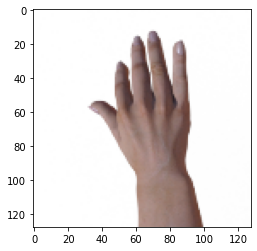

In [23]:
plt.imshow(images[0])

In [24]:
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/19, dl=0.740, d2=0.695 g=0.284
>1, 2/19, dl=0.028, d2=0.693 g=0.247
>1, 3/19, dl=0.009, d2=0.691 g=0.219
>1, 4/19, dl=0.005, d2=0.688 g=0.227
>1, 5/19, dl=0.004, d2=0.682 g=0.227
>1, 6/19, dl=0.003, d2=0.675 g=0.243
>1, 7/19, dl=0.002, d2=0.665 g=0.232
>1, 8/19, dl=0.002, d2=0.654 g=0.252
>1, 9/19, dl=0.002, d2=0.641 g=0.271
>1, 10/19, dl=0.002, d2=0.626 g=0.277
>1, 11/19, dl=0.001, d2=0.608 g=0.300
>1, 12/19, dl=0.001, d2=0.587 g=0.318
>1, 13/19, dl=0.001, d2=0.562 g=0.343
>1, 14/19, dl=0.001, d2=0.531 g=0.385
>1, 15/19, dl=0.001, d2=0.495 g=0.437
>1, 16/19, dl=0.001, d2=0.456 g=0.480
>1, 17/19, dl=0.001, d2=0.405 g=0.580
>1, 18/19, dl=0.000, d2=0.334 g=0.681
>1, 19/19, dl=0.000, d2=0.252 g=0.846
>2, 1/19, dl=0.000, d2=0.173 g=0.968
>2, 2/19, dl=0.000, d2=0.123 g=1.046
>2, 3/19, dl=0.000, d2=0.096 g=1.062
>2, 4/19, dl=0.000, d2=0.081 g=1.005
>2, 5/19, dl=0.001, d2=0.068 g=0.931
>2, 6/19, dl=0.000, d2=0.055 g=0.839
>2, 7/19, dl=0.002, d2=0.044 g=0.849
>2, 8/19, dl=0.000, d2=0.039

>12, 11/19, dl=0.000, d2=0.000 g=0.551
>12, 12/19, dl=0.000, d2=0.000 g=0.553
>12, 13/19, dl=0.000, d2=0.000 g=0.602
>12, 14/19, dl=0.000, d2=0.000 g=0.552
>12, 15/19, dl=0.000, d2=0.000 g=0.528
>12, 16/19, dl=0.000, d2=0.000 g=0.545
>12, 17/19, dl=0.000, d2=0.000 g=0.540
>12, 18/19, dl=0.000, d2=0.000 g=0.495
>12, 19/19, dl=0.000, d2=0.000 g=0.518
>13, 1/19, dl=0.000, d2=0.000 g=0.565
>13, 2/19, dl=0.000, d2=0.000 g=0.501
>13, 3/19, dl=0.000, d2=0.000 g=0.544
>13, 4/19, dl=0.000, d2=0.000 g=0.437
>13, 5/19, dl=0.000, d2=0.000 g=0.483
>13, 6/19, dl=0.000, d2=0.000 g=0.453
>13, 7/19, dl=0.000, d2=0.000 g=0.435
>13, 8/19, dl=0.000, d2=0.000 g=0.433
>13, 9/19, dl=0.000, d2=0.000 g=0.423
>13, 10/19, dl=0.000, d2=0.000 g=0.453
>13, 11/19, dl=0.000, d2=0.000 g=0.440
>13, 12/19, dl=0.000, d2=0.000 g=0.416
>13, 13/19, dl=0.000, d2=0.000 g=0.404
>13, 14/19, dl=0.000, d2=0.000 g=0.423
>13, 15/19, dl=0.000, d2=0.000 g=0.382
>13, 16/19, dl=0.000, d2=0.000 g=0.391
>13, 17/19, dl=0.000, d2=0.000 g=0

>23, 16/19, dl=0.000, d2=0.000 g=0.194
>23, 17/19, dl=0.000, d2=0.000 g=0.169
>23, 18/19, dl=0.000, d2=0.000 g=0.172
>23, 19/19, dl=0.000, d2=0.000 g=0.168
>24, 1/19, dl=0.000, d2=0.000 g=0.164
>24, 2/19, dl=0.000, d2=0.000 g=0.171
>24, 3/19, dl=0.000, d2=0.000 g=0.172
>24, 4/19, dl=0.000, d2=0.000 g=0.167
>24, 5/19, dl=0.000, d2=0.000 g=0.162
>24, 6/19, dl=0.000, d2=0.000 g=0.159
>24, 7/19, dl=0.000, d2=0.000 g=0.162
>24, 8/19, dl=0.000, d2=0.000 g=0.167
>24, 9/19, dl=0.000, d2=0.000 g=0.169
>24, 10/19, dl=0.000, d2=0.000 g=0.179
>24, 11/19, dl=0.000, d2=0.000 g=0.169
>24, 12/19, dl=0.000, d2=0.000 g=0.167
>24, 13/19, dl=0.000, d2=0.000 g=0.162
>24, 14/19, dl=0.000, d2=0.000 g=0.176
>24, 15/19, dl=0.000, d2=0.000 g=0.162
>24, 16/19, dl=0.000, d2=0.000 g=0.178
>24, 17/19, dl=0.000, d2=0.000 g=0.163
>24, 18/19, dl=0.000, d2=0.000 g=0.172
>24, 19/19, dl=0.000, d2=0.000 g=0.163
>25, 1/19, dl=0.000, d2=0.000 g=0.159
>25, 2/19, dl=0.000, d2=0.000 g=0.161
>25, 3/19, dl=0.000, d2=0.000 g=0.15

>35, 1/19, dl=0.000, d2=0.000 g=0.150
>35, 2/19, dl=0.000, d2=0.000 g=0.152
>35, 3/19, dl=0.000, d2=0.000 g=0.144
>35, 4/19, dl=0.000, d2=0.000 g=0.128
>35, 5/19, dl=0.000, d2=0.000 g=0.142
>35, 6/19, dl=0.000, d2=0.000 g=0.151
>35, 7/19, dl=0.000, d2=0.000 g=0.157
>35, 8/19, dl=0.000, d2=0.000 g=0.160
>35, 9/19, dl=0.000, d2=0.000 g=0.139
>35, 10/19, dl=0.000, d2=0.000 g=0.142
>35, 11/19, dl=0.000, d2=0.000 g=0.154
>35, 12/19, dl=0.000, d2=0.000 g=0.137
>35, 13/19, dl=0.000, d2=0.000 g=0.166
>35, 14/19, dl=0.000, d2=0.000 g=0.136
>35, 15/19, dl=0.000, d2=0.000 g=0.137
>35, 16/19, dl=0.000, d2=0.000 g=0.141
>35, 17/19, dl=0.000, d2=0.000 g=0.128
>35, 18/19, dl=0.000, d2=0.000 g=0.157
>35, 19/19, dl=0.000, d2=0.000 g=0.127
>36, 1/19, dl=0.000, d2=0.000 g=0.148
>36, 2/19, dl=0.000, d2=0.000 g=0.148
>36, 3/19, dl=0.000, d2=0.000 g=0.135
>36, 4/19, dl=0.000, d2=0.000 g=0.162
>36, 5/19, dl=0.000, d2=0.000 g=0.149
>36, 6/19, dl=0.000, d2=0.000 g=0.152
>36, 7/19, dl=0.000, d2=0.000 g=0.143
>3

>46, 6/19, dl=0.000, d2=0.000 g=0.119
>46, 7/19, dl=0.000, d2=0.000 g=0.116
>46, 8/19, dl=0.000, d2=0.000 g=0.103
>46, 9/19, dl=0.000, d2=0.000 g=0.136
>46, 10/19, dl=0.000, d2=0.000 g=0.116
>46, 11/19, dl=0.000, d2=0.000 g=0.118
>46, 12/19, dl=0.000, d2=0.000 g=0.120
>46, 13/19, dl=0.000, d2=0.000 g=0.123
>46, 14/19, dl=0.000, d2=0.000 g=0.126
>46, 15/19, dl=0.000, d2=0.000 g=0.113
>46, 16/19, dl=0.000, d2=0.000 g=0.126
>46, 17/19, dl=0.000, d2=0.000 g=0.115
>46, 18/19, dl=0.000, d2=0.000 g=0.120
>46, 19/19, dl=0.000, d2=0.000 g=0.112
>47, 1/19, dl=0.000, d2=0.000 g=0.135
>47, 2/19, dl=0.000, d2=0.000 g=0.133
>47, 3/19, dl=0.000, d2=0.000 g=0.120
>47, 4/19, dl=0.000, d2=0.000 g=0.119
>47, 5/19, dl=0.000, d2=0.000 g=0.138
>47, 6/19, dl=0.000, d2=0.000 g=0.139
>47, 7/19, dl=0.000, d2=0.000 g=0.138
>47, 8/19, dl=0.000, d2=0.000 g=0.126
>47, 9/19, dl=0.000, d2=0.000 g=0.130
>47, 10/19, dl=0.000, d2=0.000 g=0.133
>47, 11/19, dl=0.000, d2=0.000 g=0.125
>47, 12/19, dl=0.000, d2=0.000 g=0.141

>57, 11/19, dl=0.000, d2=0.000 g=0.101
>57, 12/19, dl=0.000, d2=0.000 g=0.104
>57, 13/19, dl=0.000, d2=0.000 g=0.098
>57, 14/19, dl=0.000, d2=0.000 g=0.103
>57, 15/19, dl=0.000, d2=0.000 g=0.102
>57, 16/19, dl=0.000, d2=0.000 g=0.103
>57, 17/19, dl=0.000, d2=0.000 g=0.096
>57, 18/19, dl=0.000, d2=0.000 g=0.089
>57, 19/19, dl=0.000, d2=0.000 g=0.100
>58, 1/19, dl=0.000, d2=0.000 g=0.100
>58, 2/19, dl=0.000, d2=0.000 g=0.099
>58, 3/19, dl=0.000, d2=0.000 g=0.101
>58, 4/19, dl=0.000, d2=0.000 g=0.100
>58, 5/19, dl=0.000, d2=0.000 g=0.107
>58, 6/19, dl=0.000, d2=0.000 g=0.101
>58, 7/19, dl=0.000, d2=0.000 g=0.107
>58, 8/19, dl=0.000, d2=0.000 g=0.088
>58, 9/19, dl=0.000, d2=0.000 g=0.101
>58, 10/19, dl=0.000, d2=0.000 g=0.113
>58, 11/19, dl=0.000, d2=0.000 g=0.109
>58, 12/19, dl=0.000, d2=0.000 g=0.098
>58, 13/19, dl=0.000, d2=0.000 g=0.103
>58, 14/19, dl=0.000, d2=0.000 g=0.095
>58, 15/19, dl=0.000, d2=0.000 g=0.102
>58, 16/19, dl=0.000, d2=0.000 g=0.110
>58, 17/19, dl=0.000, d2=0.000 g=0

>68, 16/19, dl=0.000, d2=0.000 g=0.107
>68, 17/19, dl=0.000, d2=0.000 g=0.109
>68, 18/19, dl=0.000, d2=0.000 g=0.096
>68, 19/19, dl=0.000, d2=0.000 g=0.101
>69, 1/19, dl=0.000, d2=0.000 g=0.101
>69, 2/19, dl=0.000, d2=0.000 g=0.101
>69, 3/19, dl=0.000, d2=0.000 g=0.100
>69, 4/19, dl=0.000, d2=0.000 g=0.100
>69, 5/19, dl=0.000, d2=0.000 g=0.103
>69, 6/19, dl=0.000, d2=0.000 g=0.102
>69, 7/19, dl=0.000, d2=0.000 g=0.101
>69, 8/19, dl=0.000, d2=0.000 g=0.094
>69, 9/19, dl=0.000, d2=0.000 g=0.100
>69, 10/19, dl=0.000, d2=0.000 g=0.094
>69, 11/19, dl=0.000, d2=0.000 g=0.100
>69, 12/19, dl=0.000, d2=0.000 g=0.101
>69, 13/19, dl=0.000, d2=0.000 g=0.107
>69, 14/19, dl=0.000, d2=0.000 g=0.106
>69, 15/19, dl=0.000, d2=0.000 g=0.099
>69, 16/19, dl=0.000, d2=0.000 g=0.112
>69, 17/19, dl=0.000, d2=0.000 g=0.131
>69, 18/19, dl=0.000, d2=0.000 g=0.122
>69, 19/19, dl=0.000, d2=0.000 g=0.118
>70, 1/19, dl=0.000, d2=0.000 g=0.119
>70, 2/19, dl=0.000, d2=0.000 g=0.105
>70, 3/19, dl=0.000, d2=0.000 g=0.12

>80, 1/19, dl=0.000, d2=0.000 g=0.091
>80, 2/19, dl=0.000, d2=0.000 g=0.099
>80, 3/19, dl=0.000, d2=0.000 g=0.094
>80, 4/19, dl=0.000, d2=0.000 g=0.095
>80, 5/19, dl=0.000, d2=0.000 g=0.099
>80, 6/19, dl=0.000, d2=0.000 g=0.097
>80, 7/19, dl=0.000, d2=0.000 g=0.107
>80, 8/19, dl=0.000, d2=0.000 g=0.095
>80, 9/19, dl=0.000, d2=0.000 g=0.108
>80, 10/19, dl=0.000, d2=0.000 g=0.098
>80, 11/19, dl=0.000, d2=0.000 g=0.102
>80, 12/19, dl=0.000, d2=0.000 g=0.100
>80, 13/19, dl=0.000, d2=0.000 g=0.099
>80, 14/19, dl=0.000, d2=0.000 g=0.102
>80, 15/19, dl=0.000, d2=0.000 g=0.097
>80, 16/19, dl=0.000, d2=0.000 g=0.099
>80, 17/19, dl=0.000, d2=0.000 g=0.099
>80, 18/19, dl=0.000, d2=0.000 g=0.108
>80, 19/19, dl=0.000, d2=0.000 g=0.104
>81, 1/19, dl=0.000, d2=0.000 g=0.091
>81, 2/19, dl=0.000, d2=0.000 g=0.106
>81, 3/19, dl=0.000, d2=0.000 g=0.102
>81, 4/19, dl=0.000, d2=0.000 g=0.092
>81, 5/19, dl=0.000, d2=0.000 g=0.100
>81, 6/19, dl=0.000, d2=0.000 g=0.098
>81, 7/19, dl=0.000, d2=0.000 g=0.093
>8

>91, 6/19, dl=0.000, d2=0.000 g=0.110
>91, 7/19, dl=0.000, d2=0.000 g=0.092
>91, 8/19, dl=0.000, d2=0.000 g=0.098
>91, 9/19, dl=0.000, d2=0.000 g=0.099
>91, 10/19, dl=0.000, d2=0.000 g=0.097
>91, 11/19, dl=0.000, d2=0.000 g=0.087
>91, 12/19, dl=0.000, d2=0.000 g=0.096
>91, 13/19, dl=0.000, d2=0.000 g=0.091
>91, 14/19, dl=0.000, d2=0.000 g=0.104
>91, 15/19, dl=0.000, d2=0.000 g=0.084
>91, 16/19, dl=0.000, d2=0.000 g=0.098
>91, 17/19, dl=0.000, d2=0.000 g=0.102
>91, 18/19, dl=0.000, d2=0.000 g=0.097
>91, 19/19, dl=0.000, d2=0.000 g=0.096
>92, 1/19, dl=0.000, d2=0.000 g=0.098
>92, 2/19, dl=0.000, d2=0.000 g=0.101
>92, 3/19, dl=0.000, d2=0.000 g=0.095
>92, 4/19, dl=0.000, d2=0.000 g=0.099
>92, 5/19, dl=0.000, d2=0.000 g=0.089
>92, 6/19, dl=0.000, d2=0.000 g=0.093
>92, 7/19, dl=0.000, d2=0.000 g=0.096
>92, 8/19, dl=0.000, d2=0.000 g=0.090
>92, 9/19, dl=0.000, d2=0.000 g=0.087
>92, 10/19, dl=0.000, d2=0.000 g=0.094
>92, 11/19, dl=0.000, d2=0.000 g=0.090
>92, 12/19, dl=0.000, d2=0.000 g=0.093

In [25]:
CLASS_NAMES = ['rock', 'paper', 'scissors']

In [26]:
def show_plot(examples, n) :
  plt.figure(figsize=(10,10))
  for i in range(n*n) :
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, ])
  plt.show()

In [27]:
model = load_model('cgan_generator.h5')

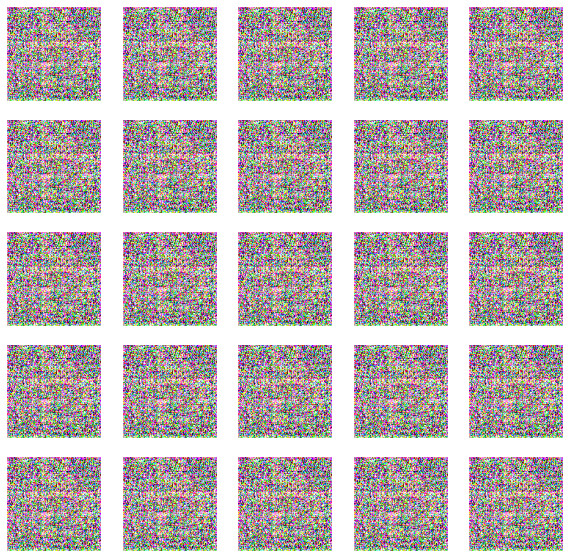

In [28]:
latent_points, labels = generate_latent_points(100, 25)
labels = asarray([0 for i in range(25)])
X = model.predict([latent_points, labels])
X = (X + 1) / 2.0
show_plot(X, 5)

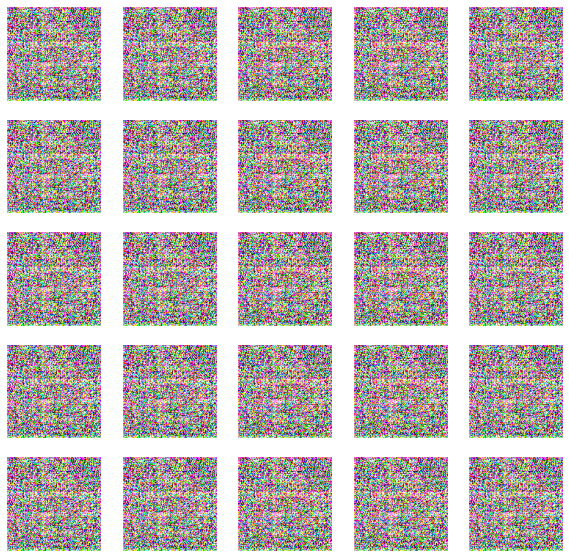

In [29]:
latent_points, labels = generate_latent_points(100, 25)
labels = asarray([1 for i in range(25)])
X = model.predict([latent_points, labels])
X = (X + 1) / 2.0
show_plot(X, 5)

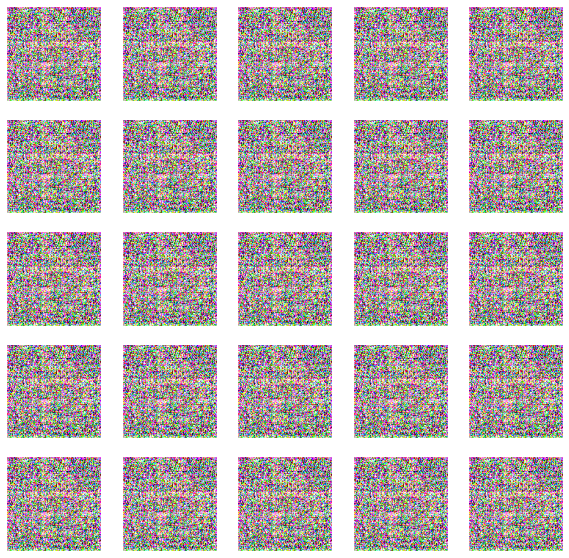

In [30]:
latent_points, labels = generate_latent_points(100, 25)
labels = asarray([2 for i in range(25)])
X = model.predict([latent_points, labels])
X = (X + 1) / 2.0
show_plot(X, 5)